In [ ]:
pip install paiutils

In [21]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from paiutils import image
from paiutils.analytics import Analyzer
from paiutils import neural_network as nn
from paiutils import autoencoder as ae
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display


In [5]:
# download dataset
import tensorflow_datasets as tfds
train_dataset, info = tfds.load('shapes3d', split='train', with_info=True)

In [6]:
# dataset information
info.features

FeaturesDict({
    'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
    'label_floor_hue': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    'label_object_hue': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    'label_orientation': ClassLabel(shape=(), dtype=tf.int64, num_classes=15),
    'label_scale': ClassLabel(shape=(), dtype=tf.int64, num_classes=8),
    'label_shape': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
    'label_wall_hue': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    'value_floor_hue': tf.float32,
    'value_object_hue': tf.float32,
    'value_orientation': tf.float32,
    'value_scale': tf.float32,
    'value_shape': tf.float32,
    'value_wall_hue': tf.float32,
})

,image,label_floor_hue,label_object_hue,label_orientation,label_scale,label_shape,label_wall_hue,value_floor_hue,value_object_hue,value_orientation,value_scale,value_shape,value_wall_hue
0,,0,4,4,1,1,3,0.0,0.4000000059604645,-12.857142448425293,0.8214285969734192,1.0,0.30000001192092896
1,,4,9,7,6,0,2,0.4000000059604645,0.8999999761581421,0.0,1.1785714626312256,0.0,0.20000000298023224
2,,9,0,10,0,1,8,0.8999999761581421,0.0,12.857142448425293,0.75,1.0,0.800000011920929
3,,7,4,12,6,1,3,0.699999988079071,0.4000000059604645,21.428571701049805,1.1785714626312256,1.0,0.30000001192092896
4,,7,5,10,1,0,7,0.699999988079071,0.5,12.857142448425293,0.8214285969734192,0.0,0.699999988079071
5,,3,3,14,5,2,3,0.30000001192092896,0.30000001192092896,30.0,1.1071428060531616,2.0,0.30000001192092896
6,,3,1,6,2,2,6,0.30000001192092896,0.10000000149011612,-4.285714149475098,0.8928571343421936,2.0,0.6000000238418579
7,,6,8,8,1,3,6,0.6000000238418579,0.800000011920929,4.285714149475098,0.8214285969734192,3.0,0.6000000238418579
8,,0,3,0,4,0,0,0.0,0.30000001192092896,-30.0,1.0357142686843872,0.0,0.0
9,,9,3,6,0,1,9,0.8999999761581421,0.30000001192092896,-4.285714149475098,0.75,1.0,0.8999999761581421

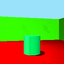
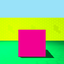
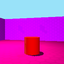
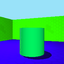
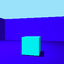
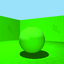
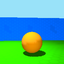
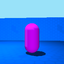
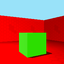
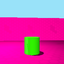

In [2]:
tfds.as_dataframe(train_dataset.take(10), info)

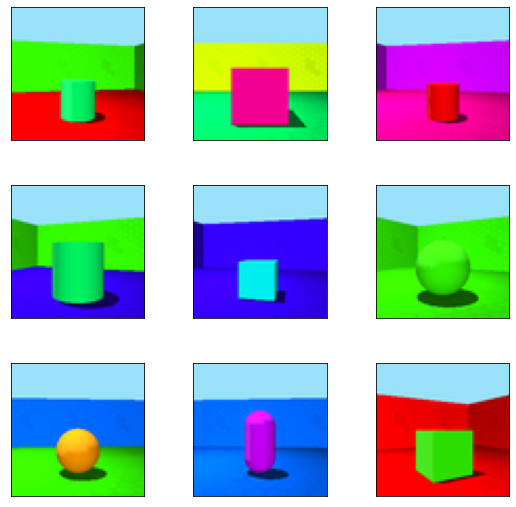

In [4]:
# dataset visualization
fig = tfds.show_examples(train_dataset, info)

In [7]:
# Preprocessing the dataset
def preprocess(x):
    x = tf.image.resize(
        x['image'], (32, 32),
        method=tf.image.ResizeMethod.AREA
    )
    x = tf.cast(x, tf.float32) / 255.0
    return x, x
train_dataset = train_dataset.map(preprocess)

In [8]:
# Spliting the dataset
data_len = len(train_dataset)
train_dataset.shuffle(data_len)
val_len = int(data_len * .1)
val_data = train_dataset.take(val_len)
train_data = train_dataset.skip(val_len)

batch_size = 32
data = {'train': train_data.repeat().batch(batch_size),
        'validation': val_data.batch(batch_size)}
shape = train_data.element_spec[0].shape

In [9]:
#building the model
latent_dim = 2
x0 = keras.layers.Input(shape=shape)
x = nn.conv2d(64, 3, 2)(x0)
x = nn.conv2d(128, 3, 2)(x)
x = nn.conv2d(256, 3, 2)(x)
x = nn.conv2d(512, 3, 2)(x)
x = keras.layers.Flatten()(x)
z_mean = keras.layers.Dense(latent_dim)(x)
z_log_var = keras.layers.Dense(latent_dim)(x)
z_log_var = keras.layers.Lambda(
    lambda x: tf.clip_by_value(x, -50, 50)  
)(z_log_var)
encoder_model = keras.Model(inputs=x0, outputs=[z_mean, z_log_var])
encoder_model.compile(optimizer='adam', loss='mse')
encoder_model.summary()

x0 = keras.layers.Input(shape=(latent_dim,))
x = nn.dense(2048)(x0)
x = keras.layers.Reshape((2, 2, 512))(x)
x = nn.conv2d(512, 3, 2, transpose=True)(x)
x = nn.conv2d(256, 3, 2, transpose=True)(x)
x = nn.conv2d(128, 3, 2, transpose=True)(x)
x = nn.conv2d(64, 3, 2, transpose=True)(x)
output = nn.conv2d(3, 1, 1, activation='linear', batch_norm=False)(x)
decoder_model = keras.Model(inputs=x0, outputs=output)
decoder_model.compile(optimizer=keras.optimizers.Adam(.0001), loss='binary_crossentropy')
decoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 128)    73856       ['batch_normalization[0][0]']

In [32]:
# training the model
steps_per_epoch = int(len(train_data) // batch_size)
trainer = ae.VAETrainer(
    encoder_model, decoder_model, data,
    rloss_coef=1000, use_logits=True
)
trainer.train(10, steps_per_epoch=steps_per_epoch)
path = trainer.save('/content/drive/MyDrive/1/2')

Epoch 1/10
13500/13500 [==============================] - 745s 54ms/step - loss: 371.4458 - reconstruction_loss: 0.3663 - divergence_loss: 5.0996 - val_loss: 0.3565
Epoch 2/10
13500/13500 [==============================] - 727s 53ms/step - loss: 350.0442 - reconstruction_loss: 0.3597 - divergence_loss: 5.1705 - val_loss: 0.3521
Epoch 3/10
13500/13500 [==============================] - 745s 54ms/step - loss: 346.8365 - reconstruction_loss: 0.3556 - divergence_loss: 5.1889 - val_loss: 0.3505
Epoch 4/10
13500/13500 [==============================] - 766s 56ms/step - loss: 343.5832 - reconstruction_loss: 0.3526 - divergence_loss: 5.2087 - val_loss: 0.3513
Epoch 5/10
13500/13500 [==============================] - 755s 55ms/step - loss: 342.3777 - reconstruction_loss: 0.3504 - divergence_loss: 5.2214 - val_loss: 0.3500
Epoch 6/10
13500/13500 [==============================] - 759s 55ms/step - loss: 340.6247 - reconstruction_loss: 0.3487 - divergence_loss: 5.2224 - val_loss: 0.3509
Epoch 7/10

In [33]:
print(trainer.eval(batch_size=100))

Train Data Evaluation: 
100/100 [==============================] - 18s 30ms/step - loss: 0.3471
Validation Data Evaluation: 
100/100 [==============================] - 3s 25ms/step - loss: 0.3462
{'Train': 0.34707286953926086, 'Validation': 0.3462214767932892}


In [10]:
predictor = ae.AutoencoderPredictor("/content/drive/MyDrive/1/2/20211204_140343_721243")

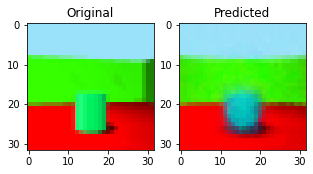

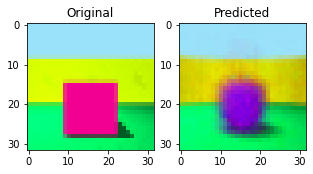

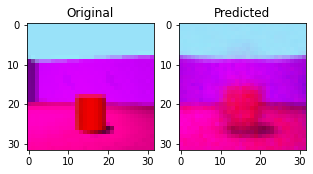

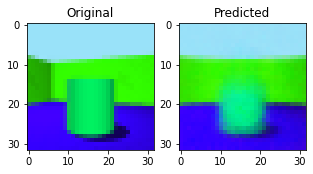

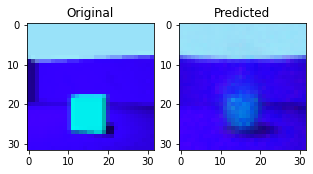

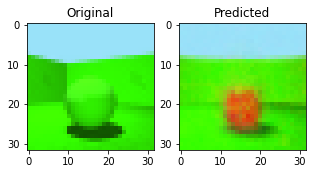

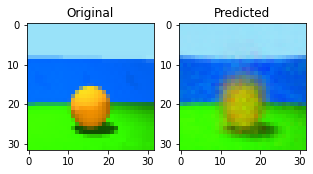

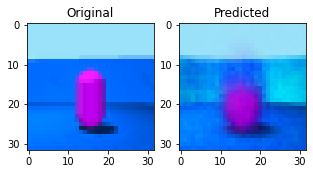

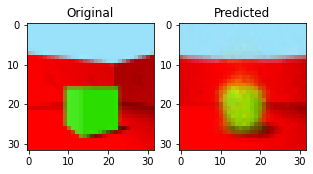

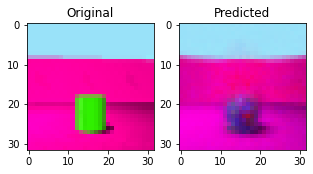

In [41]:
# plotting some example of original and predicted images
%matplotlib inline
example_data = val_data.take(10)
for example in example_data:
    example = example[0].numpy()
    pred = predictor.predict(example) * 255.0
    pred = pred.astype('uint8')
    example = (example * 255.0).astype('uint8')
    fig, axs = plt.subplots(1, 2, figsize=(5,5))
    axs[0].imshow(example)
    axs[0].set_title("Original")
    axs[1].imshow(pred)
    axs[1].set_title("Predicted")

In [12]:
encoder = ae.AutoencoderPredictor("/content/drive/MyDrive/1/2/20211204_140343_721243", uses_encoder_model=True)


In [30]:
%matplotlib notebook
sample_size = 1000
np_train_data = train_data.batch(
    sample_size
).as_numpy_iterator().next()[0]
means, logvars = encoder.predict_all(np_train_data)
variances = np.exp(logvars * .5)
mean_means = means.mean(axis=0)
mean_stds = means.std(axis=0)
print(mean_means)
print(mean_stds)


[0.07386811 0.22077051]
[1.6005565 1.7205396]


In [33]:
decoder = ae.AutoencoderPredictor("/content/drive/MyDrive/1/2/20211204_140343_721243", uses_decoder_model=True)

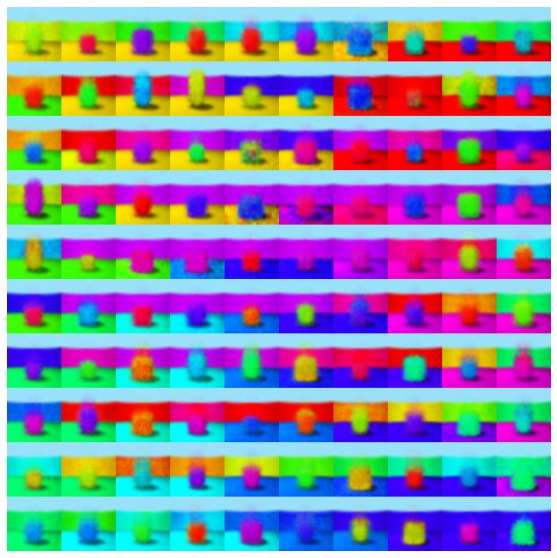

In [42]:
# Showing the 2D manifolds 
scale = int(2)
size = 32 * scale
steps = 10


xaxis = 0
yaxis = 1

norm = tfp.distributions.Normal(mean_means[xaxis],
                                mean_stds[xaxis])
grid_x = norm.quantile(np.linspace(0.05, 0.95, steps))
norm = tfp.distributions.Normal(mean_means[yaxis],
                                mean_stds[yaxis])
grid_y = norm.quantile(np.linspace(0.05, 0.95, steps))

grid = np.empty((size * steps,
                 size * steps, 3))
for _ in range(1):
    z = np.random.normal(0, 1, size=latent_dim)
    z = z * mean_stds + mean_means
    for i, y in enumerate(grid_y):
        for j, x in enumerate(grid_x):
            z[xaxis] = x
            z[yaxis] = y
            decoded = decoder.predict(z)
            decoded = tf.math.sigmoid(decoded)
            grid[i * size: (i + 1) * size,
                 j * size: (j + 1) * size] = image.pyr(decoded.numpy(), scale - 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap="Greys_r")
    plt.axis('Off')
    plt.show()
